# DIA Pipeline Analysis 01
#### Efficiency, Synthetic Sources SNR, Flux Recovery, and Configuration
This notebook is compatible with `desc-stack` kernel.

In [84]:
import sqlite3
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib as mpl
import numpy as np
import pandas as pd
from lsst.daf.persistence import Butler
import fakeInjectionPipeline_v23 as fi
import data_process_utils as dpu
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import sigmaclip
from astropy.table import Table
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()
mpl.rcParams['font.size']=14

###########################  host position #############################
def show_coadd(coadd_exp, host_table):
    # show host positions on a given coadd
    color_dict = {'20': 'r', '21': 'orange', '22': 'y', '23': 'g', '24': 'blue'}
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(interval(coadd_exp.getImage().array), cmap='gray', origin='lower')
    ax.set_axis_off()
    for idx, row in host_table.iterrows():
        coadd_x, coadd_y= row['coadd_pixel_x'], row['coadd_pixel_y']
        color_key = str(row['min_host_mag'])
        color = color_dict[color_key]
        circ = Circle((coadd_x, coadd_y), 50, color=color, fill=False)
        ax.add_patch(circ)
############################## efficiency ##############################
def cal_eff(fake_src_df):
    # fake_src_df contains the info and detection status of injected sources
    n_of_fake = len(fake_src_df)
    detected_fake = fake_src_df.loc[fake_src_df.matched_status.astype(bool)]
    eff = len(detected_fake) / n_of_fake
    err = np.sqrt( eff / n_of_fake )
    return eff, err, n_of_fake

def get_efficiency(fake_src_df, host_mag_list=None, fake_mag_list=None):
    eff_dict, err_dict, n_of_fake_dict = {}, {}, {}
    for host_mag in host_mag_list:
        efficiency_list = []
        err_list = []
        n_of_fake_list = []
        for fake_mag in fake_mag_list:
            fake_mag_str = str(fake_mag).replace('.', '')
            # fake_num, detected_fake = 0, 0
            fake_src = fake_src_df.loc[
                np.logical_and(
                    fake_src_df.host_mag == host_mag, fake_src_df.fake_mag == fake_mag_str
            )].copy().reset_index(drop=True)
            eff, err, n_of_fake = cal_eff(fake_src)
            efficiency_list.append(eff)
            err_list.append(err)
            n_of_fake_list.append(n_of_fake)
        eff_dict[host_mag] = efficiency_list
        err_dict[host_mag] = err_list
        n_of_fake_dict[host_mag] = n_of_fake_list
    return eff_dict, err_dict, n_of_fake_dict

def sigmoid(x, a, b):
    y = 1 / (1 + np.exp( - a * (x - b) ) )
    return y

def fit_eff(fake_mag_list, eff_list, x_ls):
    popt, pcov = curve_fit(sigmoid, fake_mag_list, eff_list, bounds=((-20, 0),(0, 50)))
    m50 = - 1 / popt[0] * np.log(1 / 0.5 - 1) + popt[1]
    y_ls = []
    for x in x_ls:
        y = sigmoid(x, popt[0], popt[1])
        y_ls.append(y)
    return m50, y_ls

def merge_efficiency(eff_dict, err_dict, eff_faint_dict, err_faint_dict):
    # util function to merge the efficiency from 20 - 24 and faint tail together
    eff_merged, err_merged = {}, {}
    for key in eff_dict.keys():
        eff_merged[key] = eff_dict[key][0:6] + eff_faint_dict[key]
        err_merged[key] = err_dict[key][0:6] + err_faint_dict[key]
    return eff_merged, err_merged
    
# make plots
def plot_eff(fake_mag_list, fake_src_df, fake_mag_faint_list, fake_src_faint_df):
    eff_dict, err_dict, n_of_fake_dict = get_efficiency(
        fake_src_df, host_mag_list=host_mag_list, fake_mag_list=fake_mag_list)

    eff_faint_dict, err_faint_dict, n_of_fake_faint_dict = get_efficiency(
        fake_src_faint_df, host_mag_list=host_mag_list, fake_mag_list=fake_mag_faint_list)
    
    eff_merged, err_merged = merge_efficiency(eff_dict, err_dict, eff_faint_dict, err_faint_dict)
    fake_mag_merged = [20, 20.5, 21, 21.5, 22, 22.5,
                   23.0, 23.1, 23.2, 23.3, 23.4, 23.5, 23.6, 23.7, 23.8, 23.9, 24.0]
    color_list=['r', 'orange', 'y', 'g', 'blue']
    x_ls = np.arange(20, 24.09, 0.1)
    yticks = [0., 0.2, 0.4, 0.6, 0.8, 1.]

    fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [2, 1]})

    for host_idx, host_mag in enumerate(host_mag_list):
        mag = host_mag.split('_')
        color = color_list[host_idx]
        _, y_ls = fit_eff(fake_mag_merged, eff_merged[host_mag], x_ls)
        ax[0].plot(x_ls, y_ls, color=color)
        ax[0].scatter(fake_mag_list, eff_dict[host_mag],
                   marker='o', color=color, label=f'{mag[0]}-{mag[1]} mag / asec$^2$')
    ax[0].set_xticks(fake_mag_list)
    ax[0].set_xticklabels(fake_mag_list)
    ax[0].set_yticks(yticks)
    ax[0].set_yticklabels(yticks)
    ax[0].set_xlim(20, 24.3)
    ax[0].set_ylim((0., 1.1))
    ax[0].set_ylabel(' Detection Efficiency')
    ax[0].legend()

    x_ls = np.arange(23, 24.009, 0.01)
    for host_idx, host_mag in enumerate(host_mag_list):
        mag = host_mag.split('_')
        color = color_list[host_idx]
        m50, y_ls = fit_eff(fake_mag_merged, eff_merged[host_mag], x_ls)
        print(f'host mag: {host_mag}, m50: {m50}')
        ax[1].axvline(x=m50, color=color, linestyle='--')
        ax[1].plot(x_ls, y_ls, color=color)
        ax[1].scatter(fake_mag_faint_list, eff_faint_dict[host_mag], marker='o', color=color, label=f'{mag[0]}-{mag[1]} mag / asec$^2$')
        # ax[1].axhline(y=0.5,color='gray')
    ax[1].set_xticks(fake_mag_faint_list)
    ax[1].set_xticklabels(fake_mag_faint_list)
    ax[1].set_yticks(yticks)
    ax[1].set_yticklabels(yticks)
    ax[1].set_ylim(-0.1, 1.1)
    ax[1].set_xlabel('Synthetic Source Mag')
    ax[1].set_ylabel('Detection Efficiency')
    return eff_dict
#################### snr distribution of detected fakes ###################
def restore_minor_ticks(ax):
    # restore minor ticks
    # https://stackoverflow.com/questions/44078409/matplotlib-semi-log-plot-minor-tick-marks-are-gone-when-range-is-large
    locmaj = mpl.ticker.LogLocator(base=10,numticks=5) 
    ax.xaxis.set_major_locator(locmaj)
    locmin = mpl.ticker.LogLocator(base=10,subs=(0.2,0.4,0.6,0.8),numticks=5)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

def plot_snr_distribution(fake_src_df, plot_type='log_lin'):
    # plot snr of detected fakes
    # plot type: log_lin, log_log, lin_log, lin_lin
    fig, ax = plt.subplots(2, 2, figsize=(8, 6))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    ax_ls = ax.flat
    for i, fake_mag in enumerate([21, 22, 23, 24]):
        fake_mag_str = str(fake_mag).replace('.', '')
        fake_src = fake_src_df.loc[
            fake_src_df.fake_mag == fake_mag_str
        ].copy().reset_index(drop=True)
        detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
        snr = detected_fake.base_PsfFlux_instFlux / detected_fake.base_PsfFlux_instFluxErr
        eff = len(detected_fake) / len(fake_src)

        ax_ls[i].set_xlim(1e0, 1e2)
        ax_ls[i].set_ylim(1e-1, 1e3+500)
        if plot_type == 'log_log':
            ax_ls[i].hist(snr, histtype='step', color='orange',
              bins=np.logspace(np.log10(0.1),np.log10(1e4), 100), label='SNR')
            ax_ls[i].set_xscale('log')
            ax_ls[i].set_yscale('log')
            restore_minor_ticks(ax_ls[i])
        elif plot_type == 'lin_lin':
            ax_ls[i].hist(snr, histtype='step', color='orange', bins=np.linspace(0, 1e2, 50), label='SNR')
        elif plot_type == 'log_lin':
            ax_ls[i].hist(snr, histtype='step', color='orange',
              bins=np.logspace(np.log10(0.1),np.log10(1e4), 100), label='SNR')
            ax_ls[i].set_xscale('log')
            restore_minor_ticks(ax_ls[i])
        elif plot_type == 'lin_log':
            ax_ls[i].hist(snr, histtype='step', color='orange', bins=np.linspace(0, 1e2, 50), label='SNR')
            ax_ls[i].set_yscale('log')
        else:
            print('plot type is not valid')
            break
        ax_ls[i].text(1.5,500, f'Eff = {eff:.2f}', color='r')
        ax_ls[i].axvline(x=5.5, linewidth='1', linestyle='--', color='gray', label='5.5 threshold')
        ax_ls[i].set_title(f'Synthetic Source Mag: {fake_mag}', size=14)
        if i%2==0:
            ax_ls[i].set_ylabel('Count')
        if i > 1:
            ax_ls[i].set_xlabel('SNR')
        ax_ls[i].legend(fontsize=12)

################################ flux pull ################################
def plot_flux_pull(fake_src_full, remove_outlier=False, threshold=5):
    norm_x = np.arange(-5, 5, 0.1)
    norm_y = norm.pdf(norm_x)

    fig, ax = plt.subplots(2, 2, figsize=(8, 6))
    fig.subplots_adjust(hspace=0.5, wspace=0.4)
    ax_ls = ax.flat
    bins = np.linspace(-5, 5, 200)
    for i, fake_mag in enumerate([21, 22, 23, 24]):

        fake_mag_str = str(fake_mag).replace('.', '')
        fake_src = fake_src_full.loc[
            fake_src_full.fake_mag == fake_mag_str
        ].copy().reset_index(drop=True)
        detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
        dflux = (detected_fake.base_PsfFlux_instFlux - detected_fake.injected_instFlux) / detected_fake.base_PsfFlux_instFluxErr
        if remove_outlier:
            dflux, _, _ = sigmaclip(dflux, threshold, threshold)
        mean_dflux = np.mean(dflux)
        std_dflux = np.std(dflux)
        

        ax_ls[i].hist(dflux, histtype='step', color='orange', density=True,
                      bins=bins, label=f'D({mean_dflux:.3f}, {std_dflux:.3f})')
        ax_ls[i].plot(norm_x, norm_y, color='k', label='N(0, 1)')
        ax_ls[i].set_xlim(-5, 5)
        ax_ls[i].set_ylim(0., 1)
        ax_ls[i].set_title(f'Source Mag: {fake_mag}')

        if i > 1:
            ax_ls[i].set_xlabel('$\Delta f / \sigma$')
        if i%2==0:
            ax_ls[i].set_ylabel('Density')
        ax_ls[i].legend(fontsize=12)
############################## config ##############################


def get_dflux_and_ar(config, fake_mag):
    # get flux pull and artifact rate (1 / deg^2)
    # In order to avoid repeated artifacts, only artifacts from 20-21 host mag are used
    n_of_calexp = 7 * 10
    # Pixel Scale: 0.199859 arcsec/pixel
    # calexp image size: 4000 * 4072
    det_to_deg2 = 1 / (4000 * 0.2 / 3600 * 4072 * 0.2 / 3600)
    
    flux_db_patch = f'./data/patch_0to6/diff/{config}/detection/detection.sqlite'
    conn = sqlite3.connect(flux_db_patch)
    flux_query = (
        'SELECT base_PsfFlux_instFlux, injected_instFlux, base_PsfFlux_instFluxErr, host_mag, '
        f'fake_mag, matched_status FROM fake_src WHERE fake_mag = {fake_mag}')
    diaSrc = pd.read_sql_query(flux_query, conn)
    detected_fake = diaSrc.loc[diaSrc.matched_status.astype(bool)]
    eff = len(detected_fake.loc[detected_fake.host_mag=='20_21']) / len(diaSrc.loc[diaSrc.host_mag=='20_21'])
    dflux = (detected_fake.base_PsfFlux_instFlux - detected_fake.injected_instFlux) / detected_fake.base_PsfFlux_instFluxErr
    
    art_query = (
        "SELECT * "
        f"FROM artifact WHERE host_mag = '20_21' and fake_mag = {fake_mag}")
    art = pd.read_sql_query(art_query, conn)
    art_per_calexp = len(art) / n_of_calexp
    art_per_deg2 = art_per_calexp * det_to_deg2
    return dflux, eff, art_per_deg2

def plot_config(config, fake_mag, title):
    fontsize = 14
    bins = np.linspace(-5, 5, 200)
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    fig.subplots_adjust(hspace=0.7, wspace=0.7)

    norm_x = np.arange(-5, 5, 0.1)
    norm_y = norm.pdf(norm_x)

    dflux, eff, ar = get_dflux_and_ar(config, fake_mag)
    c_mean = np.nanmean(dflux)
    c_std = np.nanstd(dflux)
    
    default_dflux, _, _ = get_dflux_and_ar('al_default_v23', fake_mag)
    d_mean, d_std = np.nanmean(default_dflux), np.nanstd(default_dflux)
    
    ax.hist(dflux, density=True, bins=bins,color='blue', histtype='step', label=f'C({c_mean:.1f}, {c_std:.1f})')
    ax.hist(default_dflux, density=True, bins=bins,color='orange', alpha=0.5, histtype='step', label=f'D({d_mean:.1f}, {d_std:.1f})')
    ax.plot(norm_x, norm_y, color='k', label='N(0, 1)')
    ax.set_xlim((-5, 5))
    ax.set_ylim((0, 0.5))
    
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.set_title(title , size=fontsize)
    ax.set_xlabel('$\Delta f / \sigma$', size=fontsize)
    ax.set_ylabel('Density', size=fontsize)
    ax.legend(title=f'   Eff: {eff: .2f}, AR(deg$^{{-2}}$): {int(ar)}',fontsize=fontsize)
    
def plot_spatial_dof(config, fake_mag, title, spatial_dof):
    fontsize = 14
    bins = np.linspace(-5, 5, 200)
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    fig.subplots_adjust(hspace=0.7, wspace=0.7)

    norm_x = np.arange(-5, 5, 0.1)
    norm_y = norm.pdf(norm_x)

    dflux, eff, ar = get_dflux_and_ar(config, fake_mag)
    c_mean = np.nanmean(dflux)
    c_std = np.nanstd(dflux)
    
    default_dflux, _, _ = get_dflux_and_ar('al_default_v23', fake_mag)
    d_mean, d_std = np.nanmean(default_dflux), np.nanstd(default_dflux)
    
    ax.plot(norm_x, norm_y, color='k', label='N(0, 1)')
    ax.hist(default_dflux, density=True, bins=bins,color='orange',histtype='step', label=f'$d_s=1$ ({d_mean:.1f}, {d_std:.1f})')
    ax.hist(dflux, density=True, bins=bins,color='blue', alpha=0.5, histtype='step', label=f'$d_s={spatial_dof}$ ({c_mean:.1f}, {c_std:.1f})')
    
    ax.set_xlim((-5, 5))
    ax.set_ylim((0, 0.5))
    
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.set_title(title , size=fontsize)
    ax.set_xlabel('$\Delta f / \sigma$', size=fontsize)
    ax.set_ylabel('Density', size=fontsize)
    ax.legend(title=f'   Eff: {eff: .2f}, AR(deg$^{{-2}}$): {int(ar)}',fontsize=fontsize)

#### Injection location for patch 00

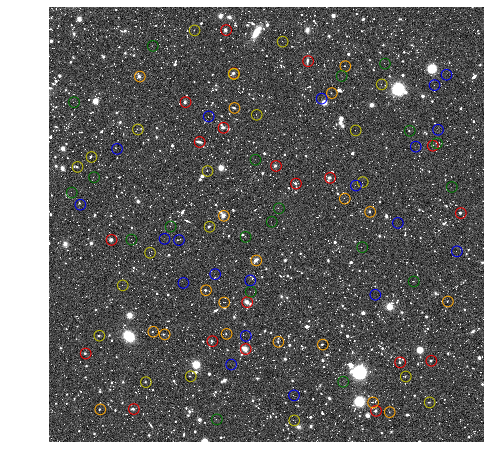

In [2]:
tract, patch, filt = 4639, 0, 'i'
coadd_repo = '/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy'
coadd_butler = Butler(coadd_repo)
coadd_id = {'tract': tract, 'patch': f'{patch},{patch}', 'filter': filt}
coadd_exp = coadd_butler.get('deepCoadd', coadd_id)

host_table = pd.read_csv('./data/table/gal_4639/gal_s2n_cut20.csv')
host_table = host_table.loc[host_table.patch_1==patch]
host_table = host_table.loc[host_table.min_host_mag >= 20]
host_table = host_table.loc[host_table.min_host_mag <= 24]

show_coadd(coadd_exp, host_table)
plt.savefig('./plots_and_tables/host_position.pdf')

#### Efficiency

host mag: 20_21, m50: 23.40115445103161
host mag: 21_22, m50: 23.546103080980583
host mag: 22_23, m50: 23.640393147007757
host mag: 23_24, m50: 23.65644537768273
host mag: 24_25, m50: 23.714381101633293


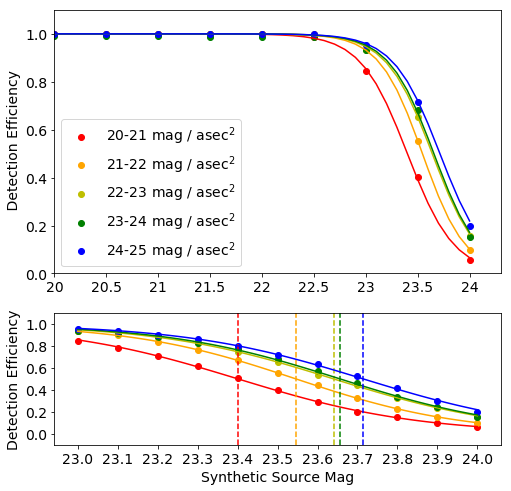

In [8]:
conn = sqlite3.connect('./data/patch_0to6/diff/al_default_v23/detection/detection.sqlite')
query = 'SELECT * FROM fake_src'
fake_src_df = pd.read_sql_query(query, conn)

conn = sqlite3.connect('./data/patch_0to6/diff_faint/al_default_v23/detection/detection.sqlite')
query = (f"SELECT * FROM fake_src")
fake_src_faint_df = pd.read_sql_query(query, conn)

host_mag_list = ['20_21', '21_22', '22_23', '23_24', '24_25']
fake_mag_list = [20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24]
fake_mag_faint_list = [23.0, 23.1, 23.2, 23.3, 23.4, 23.5, 23.6, 23.7, 23.8, 23.9, 24.0]

eff_dict = plot_eff(fake_mag_list, fake_src_df, fake_mag_faint_list, fake_src_faint_df)
plt.savefig('./plots_and_tables/eff.pdf')

In [10]:
# Efficiency from 23-24 mag is slightly off 1.
eff_dict['23_24']

[0.9923922231614539,
 0.9932375316990701,
 0.9932375316990701,
 0.989010989010989,
 0.9873203719357565,
 0.9856297548605241,
 0.9332206255283179,
 0.6804733727810651,
 0.15131022823330514]

#### SNR distribution of detected sources

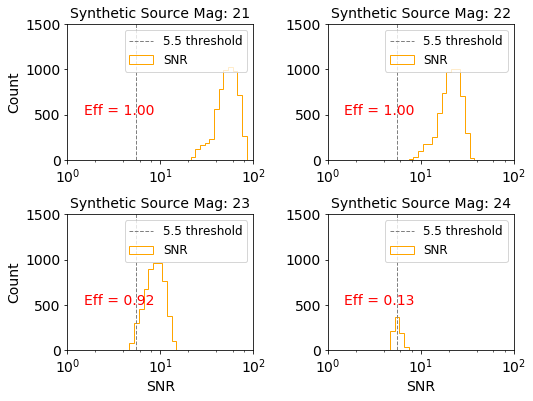

In [12]:
conn = sqlite3.connect('./data/patch_0to6/diff/al_default_v23/detection/detection.sqlite')
query = 'SELECT * FROM fake_src'
fake_src_df = pd.read_sql_query(query, conn)
plot_snr_distribution(fake_src_df, plot_type='log_lin')
plt.savefig('./plots_and_tables/snr_threshold.pdf')
"""
# plot_snr_distribution(plot_type='log_log')
# plot_snr_distribution(plot_type='lin_lin')
# plot_snr_distribution(plot_type='lin_log')
""";

#### Flux pull distribution

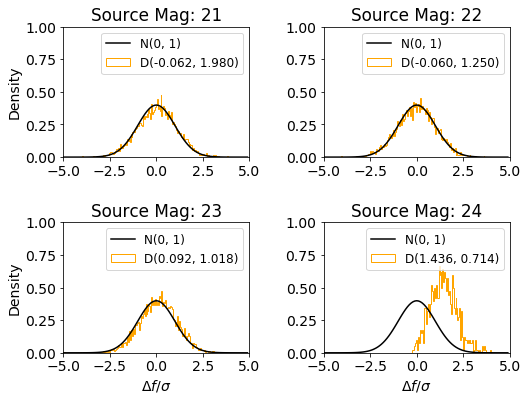

In [78]:
flux_db_patch = (
        f'./data'
        f'/patch_0to6/diff/al_default_v23/detection/detection.sqlite'
)
conn = sqlite3.connect(flux_db_patch)
full_query = 'SELECT * FROM fake_src'
fake_src_full = pd.read_sql_query(full_query, conn)
plot_flux_pull(fake_src_full, remove_outlier=False)
plt.savefig('./plots_and_tables/pull.pdf')

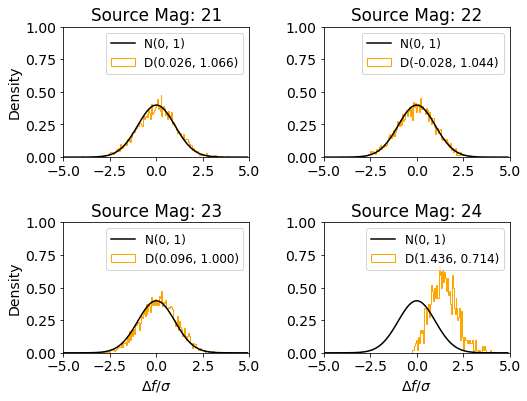

In [87]:
# remove outlier
plot_flux_pull(fake_src_full, remove_outlier=True, threshold=5)

#### Kernel spatial DOF

##### MAG20

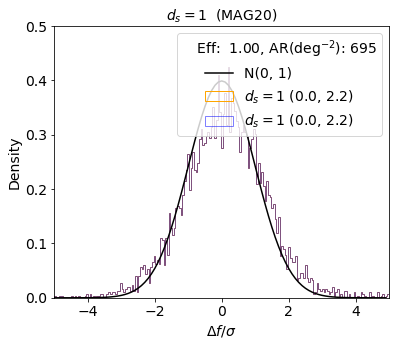

In [61]:
spatial_dof = 1
config = f'al_spatial{spatial_dof}_v23'
fake_mag = 20
save_path = f'./plots_and_tables/config_{config}_m{fake_mag}.pdf'
plot_spatial_dof(f'{config}', fake_mag, f"$d_s={spatial_dof}$  (MAG{fake_mag})", spatial_dof)
plt.savefig(save_path)

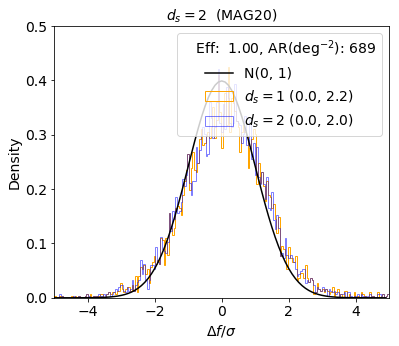

In [62]:
spatial_dof = 2
config = f'al_spatial{spatial_dof}_v23'
fake_mag = 20
save_path = f'./plots_and_tables/config_{config}_m{fake_mag}.pdf'
plot_spatial_dof(f'{config}', fake_mag, f"$d_s={spatial_dof}$  (MAG{fake_mag})", spatial_dof)
plt.savefig(save_path)

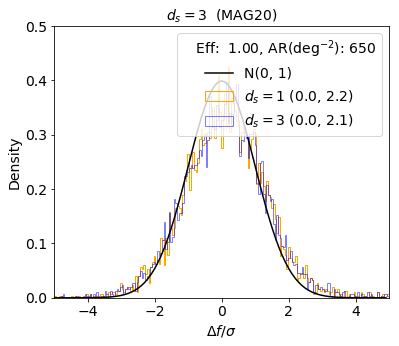

In [63]:
spatial_dof = 3
config = f'al_spatial{spatial_dof}_v23'
fake_mag = 20
save_path = f'./plots_and_tables/config_{config}_m{fake_mag}.pdf'
plot_spatial_dof(f'{config}', fake_mag, f"$d_s={spatial_dof}$  (MAG{fake_mag})", spatial_dof)
plt.savefig(save_path)

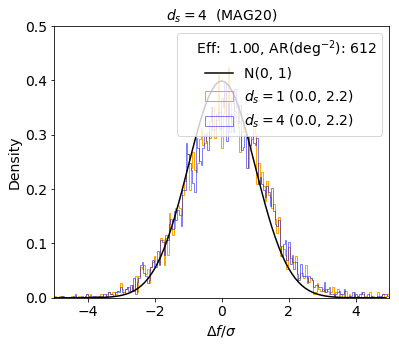

In [64]:
spatial_dof = 4
config = f'al_spatial{spatial_dof}_v23'
fake_mag = 20
save_path = f'./plots_and_tables/config_{config}_m{fake_mag}.pdf'
plot_spatial_dof(f'{config}', fake_mag, f"$d_s={spatial_dof}$  (MAG{fake_mag})", spatial_dof)
plt.savefig(save_path)

In [65]:
"""
config = 'al_default_v23' # config = 'al_preconv_v23', config = 'al_decorr_v23', config = 'al_convSciDecorr_v23'
fake_mag = 20
save_path = f'./plots_and_tables/config_{config}_m{fake_mag}.pdf'
plot_config(f'{config}', fake_mag, f"{config.split('_')[1]} (MAG{fake_mag})")
plt.savefig(save_path)

config = 'al_convSci_v23'
fake_mag = 20
save_path = f'./plots_and_tables/config_{config}_m{fake_mag}.pdf'
plot_config(f'{config}', fake_mag, f"{config.split('_')[1]} (MAG{fake_mag})")
plt.savefig(save_path)

config = 'al_spatial4Pca_v23'
fake_mag = 20
save_path = f'./plots_and_tables/config_{config}_m{fake_mag}.pdf'
plot_config(f'{config}', fake_mag, f"spatial4PCA (MAG{fake_mag})")
plt.savefig(save_path)
""";

##### MAG23

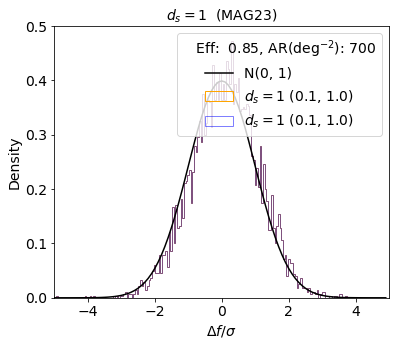

In [66]:
spatial_dof = 1
config = f'al_spatial{spatial_dof}_v23'
fake_mag = 23
save_path = f'./plots_and_tables/config_{config}_m{fake_mag}.pdf'
plot_spatial_dof(f'{config}', fake_mag, f"$d_s={spatial_dof}$  (MAG{fake_mag})", spatial_dof)
plt.savefig(save_path)

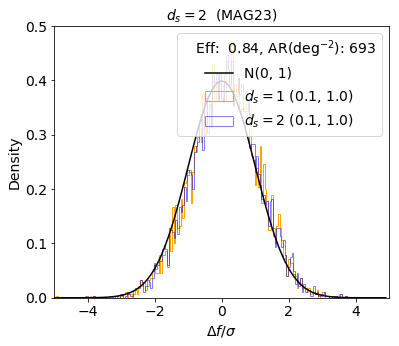

In [67]:
spatial_dof = 2
config = f'al_spatial{spatial_dof}_v23'
fake_mag = 23
save_path = f'./plots_and_tables/config_{config}_m{fake_mag}.pdf'
plot_spatial_dof(f'{config}', fake_mag, f"$d_s={spatial_dof}$  (MAG{fake_mag})", spatial_dof)
plt.savefig(save_path)

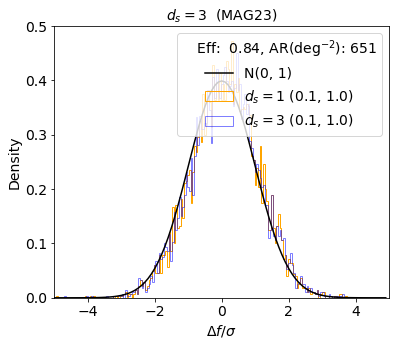

In [68]:
spatial_dof = 3
config = f'al_spatial{spatial_dof}_v23'
fake_mag = 23
save_path = f'./plots_and_tables/config_{config}_m{fake_mag}.pdf'
plot_spatial_dof(f'{config}', fake_mag, f"$d_s={spatial_dof}$  (MAG{fake_mag})", spatial_dof)
plt.savefig(save_path)

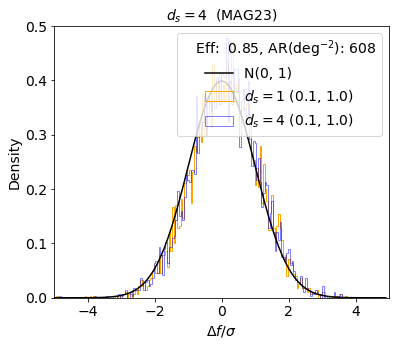

In [69]:
spatial_dof = 4
config = f'al_spatial{spatial_dof}_v23'
fake_mag = 23
save_path = f'./plots_and_tables/config_{config}_m{fake_mag}.pdf'
plot_spatial_dof(f'{config}', fake_mag, f"$d_s={spatial_dof}$  (MAG{fake_mag})", spatial_dof)
plt.savefig(save_path)

In [38]:
"""
config = 'al_default_v23' # config = 'al_preconv_v23', config = 'al_decorr_v23', config = 'al_convSciDecorr_v23'
fake_mag = 23
save_path = f'./plots_and_tables/config_{config}_m{fake_mag}.pdf'
plot_config(f'{config}', fake_mag, f"{config.split('_')[1]} (MAG{fake_mag})")
plt.savefig(save_path)

config = 'al_convSci_v23'
fake_mag = 23
save_path = f'./plots_and_tables/config_{config}_m{fake_mag}.pdf'
plot_config(f'{config}', fake_mag, f"{config.split('_')[1]} (MAG{fake_mag})")
plt.savefig(save_path)

config = 'al_spatial4Pca_v23'
fake_mag = 23
save_path = f'./plots_and_tables/config_{config}_m{fake_mag}.pdf'
plot_config(f'{config}', fake_mag, f"spatial4PCA (MAG{fake_mag})")
plt.savefig(save_path)
""";